In [17]:
from utils import preprocess_image, run_inference
image_path = "./26.png"

img = preprocess_image(image_path)
# print(img.shape)
x,y = run_inference(img)

In [18]:
x.shape, y.shape

(torch.Size([1, 3, 256, 256]), torch.Size([1, 1, 256, 256]))

In [19]:
import matplotlib.pyplot as plt

In [23]:
x_= x.squeeze(0).permute(1,2,0)
x_.cpu().numpy()
x_.shape

torch.Size([256, 256, 3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


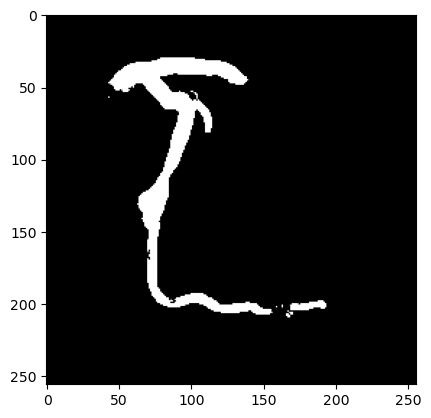

In [24]:
plt.imshow(x_,cmap='gray')

In [42]:
y_= op.squeeze(0).permute(1,2,0)
y_.cpu().numpy()
y_.shape

torch.Size([256, 256, 1])

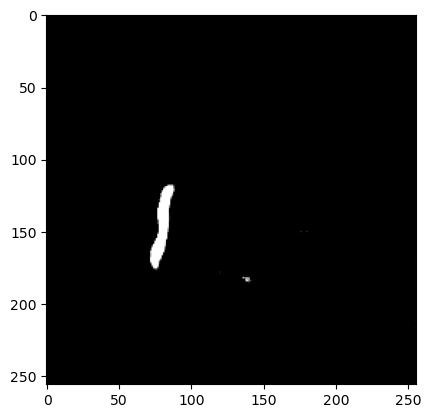

In [43]:
plt.imshow(y_,cmap='gray')

In [28]:
from Enet import ENet
import torch

model = ENet(1)

model.load_state_dict(
        torch.load(
            "./student_enet2_KD.pth",
            map_location=torch.device('cpu'),
            weights_only=True 
        )
    )

model.eval()

ENet(
  (initial): InitialBlock(
    (main_branch): Conv2d(3, 13, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (ext_branch): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (batch_norm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (prelu): PReLU(num_parameters=1)
  )
  (bottleneck1_0): Bottleneck(
    (conv1x1_1): Sequential(
      (0): Conv2d(16, 4, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): PReLU(num_parameters=1)
    )
    (conv2x2): Sequential(
      (0): Conv2d(4, 4, kernel_size=(2, 2), stride=(2, 2), bias=False)
      (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): PReLU(num_parameters=1)
    )
    (conv1x1_2): Sequential(
      (0): Conv2d(4, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum

In [40]:
from PIL import Image
from torchvision import transforms

img = Image.open("./30.png").convert("RGB")

print(type(img))

tr = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor()
])

img = tr(img)

print(type(img))
print(img.shape)
img = img.unsqueeze(dim=0)
print(img.shape)


with torch.no_grad():
    op = model(img)

    op = torch.sigmoid(op)

<class 'PIL.Image.Image'>
<class 'torch.Tensor'>
torch.Size([3, 256, 256])
torch.Size([1, 3, 256, 256])


In [41]:
op.shape

torch.Size([1, 1, 256, 256])

In [57]:
model1 = torch.load("./model1_scripted.pt")
model2 = torch.load("./model2_scripted.pt")
# print("Model 1:", model1)
# print("Model 2:", model2)

/tmp/ipykernel_61697/1944991300.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model1 = torch.load("./model1_scripted.pt")
/home/student/anaconda3/lib/python3.12/site-p

In [58]:
import torch
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import torchvision.transforms as transforms

# Load image
image_path = "26.png"
image = Image.open(image_path).convert("RGB")  # Ensure 3-channel RGB

# Preprocessing pipeline (adjust per model requirements)
preprocess = transforms.Compose([
    transforms.Resize((256, 256)),        # Resize to expected input shape
    transforms.ToTensor(),                # Convert to tensor [0, 1]
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet stats
])

input_tensor = preprocess(image).unsqueeze(0)  # Add batch dim: [1, 3, 224, 224]
print("Input shape:", input_tensor.shape)

Input shape: torch.Size([1, 3, 256, 256])


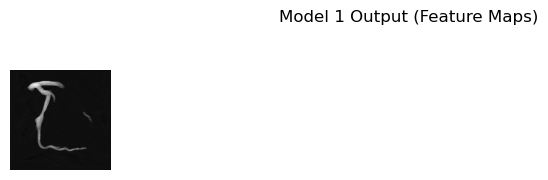

(256, 256, 3)


In [82]:
with torch.no_grad():
    output1 = model1(input_tensor)

# Plot Model 1's output (adjust based on output type)
if output1.dim() == 4:  # Feature maps (e.g., from a CNN layer)
    plt.figure(figsize=(12, 6))
    plt.suptitle("Model 1 Output (Feature Maps)")
    for i in range(min(16, output1.shape[1])):  # Plot first 16 channels
        plt.subplot(4, 4, i+1)
        plt.imshow(output1[0, i].cpu().numpy(), cmap='gray')
        plt.axis('off')
else:  # Classification logits or other 1D/2D output
    plt.figure()
    if output1.shape[1] > 1:  # Multi-class
        plt.bar(range(output1.shape[1]), output1.squeeze().cpu().numpy())
        plt.title("Model 1 Output (Class Probabilities)")
    else:  # Regression or binary
        plt.title(f"Model 1 Output: {output1.item():.4f}")
plt.show()

op = torch.sigmoid(output1).squeeze(0).repeat(3,1,1).permute(1,2,0).cpu().numpy()
print(op.shape)
plt.imsave("op.png",op)

In [78]:
output1.shape

torch.Size([1, 1, 256, 256])

In [79]:
# Ensure compatibility (reshape/normalize if needed)
output1 = output1.repeat(1,3,1,1)

In [83]:
inp = Image.open("op.png").convert("RGB")


tr = transforms.Compose([
    transforms.ToTensor()
])

inp = tr(inp)
inp = inp.unsqueeze(dim=0)
inp.shape

torch.Size([1, 3, 256, 256])

In [90]:
from torchvision.transforms import functional as TF

def preprocess_image(image_path):
    """Preprocess the input image for model1."""
    inp = Image.open(image_path).convert("RGB")
    tr = transforms.Compose([
        transforms.Resize((256,256)),
        transforms.ToTensor()
    ])
    inp = tr(inp).unsqueeze(0)
    return inp

def run_inference(image_tensor):
    """Run inference through both models with reprocessing for model2."""
    with torch.no_grad():
        # Stage 1: Model 1 Inference
        output1 = model1(image_tensor)
        output1 = torch.sigmoid(output1)  # Single-channel mask in [0, 1]

        # Convert to PIL image to mimic save-load behavior
        output1_img = TF.to_pil_image(output1.squeeze())  # Converts to single-channel PIL image
        
        # Reprocess for model2: Convert to 3-channel RGB
        output1_img_rgb = output1_img.convert("RGB")
        output1_tensor = transforms.ToTensor()(output1_img_rgb).unsqueeze(0)

        # Stage 2: Model 2 Inference
        output2 = model2(output1_tensor)
        output2 = torch.sigmoid(output2)

    return output1, output2


img_path = "./26.png"
img = preprocess_image(img_path)
output1,output2 = run_inference(img)

In [92]:
output1.shape,output2.shape

(torch.Size([1, 1, 256, 256]), torch.Size([1, 1, 256, 256]))

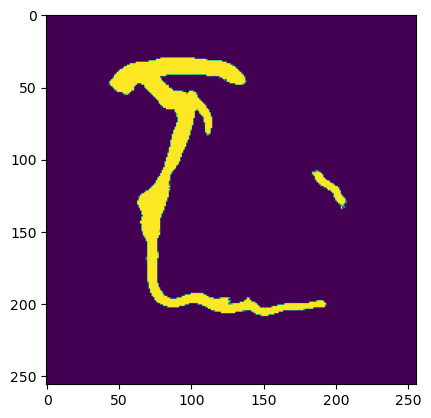

In [93]:
op1 = output1.squeeze(0).permute(1, 2, 0).cpu().numpy()

plt.imshow(op1)

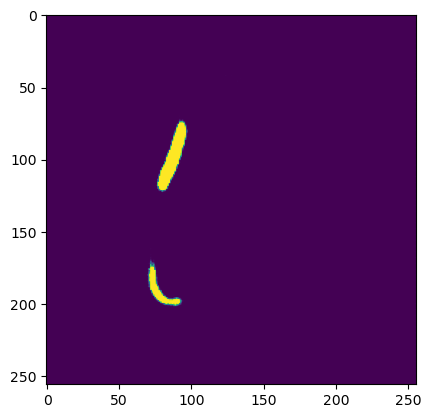

In [94]:
op2 = output2.squeeze(0).permute(1, 2, 0).cpu().numpy()

plt.imshow(op2)

In [ ]:





with torch.no_grad():
    output2 = model2(inp)

output2 = torch.sigmoid(output2)

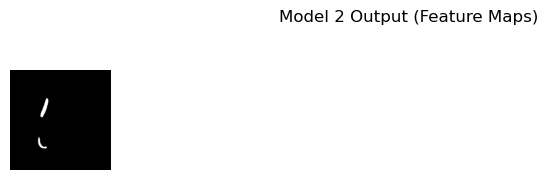

In [85]:
# Plot Model 2's output (customize based on task)
if output2.dim() == 4:  # Feature maps
    plt.figure(figsize=(12, 6))
    plt.suptitle("Model 2 Output (Feature Maps)")
    for i in range(min(16, output2.shape[1])):
        plt.subplot(4, 4, i+1)
        plt.imshow(output2[0, i].cpu().numpy(), cmap='gray')
        plt.axis('off')
elif output2.shape[1] == 3:  # RGB image (e.g., generative model)
    output_image = output2.squeeze().permute(1, 2, 0).cpu().numpy()
    output_image = np.clip((output_image * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]), 0, 1)  # Undo normalization
    plt.imshow(output_image)
    plt.title("Model 2 Output (Image)")
else:  # Logits or scalar
    plt.figure()
    plt.title(f"Model 2 Output: {output2.cpu().numpy()}")
plt.show()